<a href="https://colab.research.google.com/github/Sapnadarshi/colab/blob/main/sih_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

# Define custom dataset for paired images
class PairedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_pairs = self.load_image_pairs()

    def load_image_pairs(self):
        pairs = []
        for filename in os.listdir(self.root_dir):
            if "_A" in filename:
                input_img = os.path.join(self.root_dir, filename)
                target_img = os.path.join(self.root_dir, filename.replace("_A", "_B"))
                pairs.append((input_img, target_img))
        return pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_img_path, target_img_path = self.image_pairs[idx]
        input_img = Image.open(input_img_path).convert('L')  # Convert to grayscale
        target_img = Image.open(target_img_path).convert('RGB')

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # For grayscale image
])

# Load dataset
train_dataset = PairedDataset(root_dir='/content/drive/MyDrive/colorization_dataset/', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define the U-Net generator
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, dropout=0.0):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                      nn.BatchNorm2d(out_channels),
                      nn.ReLU(inplace=True)]
            if dropout:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        self.down1 = down_block(in_channels, 64, normalize=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)
        self.down7 = down_block(512, 512)
        self.down8 = down_block(512, 512, normalize=False)

        self.up1 = up_block(512, 512, dropout=0.5)
        self.up2 = up_block(1024, 512, dropout=0.5)
        self.up3 = up_block(1024, 512, dropout=0.5)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))

        return u8

# Define the PatchGAN discriminator
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchGANDiscriminator, self).__init__()

        def block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            block(in_channels +1, 64, normalize=False),
            block(64, 128),
            block(128, 256),
            block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)

# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    for i, (input_img, target_img) in enumerate(tqdm(train_dataloader)):
        input_img = input_img.to(device)
        target_img = target_img.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_output = discriminator(target_img, input_img)
        fake_img = generator(input_img).detach()
        fake_output = discriminator(fake_img, input_img)
        d_loss_real = adversarial_loss(real_output, torch.ones_like(real_output))
        d_loss_fake = adversarial_loss(fake_output, torch.zeros_like(fake_output))
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_img = generator(input_img)
        fake_output = discriminator(fake_img, input_img)
        g_adv_loss = adversarial_loss(fake_output, torch.ones_like(fake_output))
        g_l1_loss = l1_loss(fake_img, target_img)
        g_loss = g_adv_loss + 100 * g_l1_loss
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_dataloader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

    # Save model checkpoints
torch.save(generator.state_dict(), 'generator_epoch.pth')
torch.save(discriminator.state_dict(), 'discriminator_epoch.pth')


 20%|██        | 1/5 [00:01<00:04,  1.02s/it]

Epoch [0/100], Step [0/5], D Loss: 0.7213026285171509, G Loss: 77.88002014160156


 20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Epoch [1/100], Step [0/5], D Loss: 0.6247506141662598, G Loss: 40.331790924072266


 20%|██        | 1/5 [00:00<00:02,  1.59it/s]

Epoch [2/100], Step [0/5], D Loss: 0.5334135293960571, G Loss: 29.014205932617188


 20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Epoch [3/100], Step [0/5], D Loss: 0.416769802570343, G Loss: 26.439138412475586


 40%|████      | 2/5 [00:00<00:01,  2.65it/s]

Epoch [4/100], Step [0/5], D Loss: 0.2588713467121124, G Loss: 22.38254165649414


 40%|████      | 2/5 [00:00<00:01,  2.64it/s]

Epoch [5/100], Step [0/5], D Loss: 0.16531726717948914, G Loss: 21.17003059387207


 20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Epoch [6/100], Step [0/5], D Loss: 0.8031057119369507, G Loss: 19.987180709838867


 20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Epoch [7/100], Step [0/5], D Loss: 0.3678852319717407, G Loss: 17.547285079956055


 40%|████      | 2/5 [00:00<00:01,  2.70it/s]

Epoch [8/100], Step [0/5], D Loss: 0.30638226866722107, G Loss: 18.320465087890625


 40%|████      | 2/5 [00:00<00:01,  2.64it/s]

Epoch [9/100], Step [0/5], D Loss: 0.5197444558143616, G Loss: 18.427268981933594


 40%|████      | 2/5 [00:00<00:01,  2.62it/s]

Epoch [10/100], Step [0/5], D Loss: 0.5439269542694092, G Loss: 16.594852447509766


 20%|██        | 1/5 [00:00<00:02,  1.59it/s]

Epoch [11/100], Step [0/5], D Loss: 0.2806572914123535, G Loss: 16.287084579467773


 20%|██        | 1/5 [00:00<00:02,  1.44it/s]

Epoch [12/100], Step [0/5], D Loss: 0.6187787055969238, G Loss: 17.169612884521484


 20%|██        | 1/5 [00:00<00:02,  1.52it/s]

Epoch [13/100], Step [0/5], D Loss: 0.4600120186805725, G Loss: 17.30561065673828


 40%|████      | 2/5 [00:00<00:01,  2.65it/s]

Epoch [14/100], Step [0/5], D Loss: 0.684948742389679, G Loss: 14.661234855651855


 40%|████      | 2/5 [00:00<00:01,  2.60it/s]

Epoch [15/100], Step [0/5], D Loss: 0.517757773399353, G Loss: 14.861530303955078


 40%|████      | 2/5 [00:00<00:01,  2.60it/s]

Epoch [16/100], Step [0/5], D Loss: 0.38881438970565796, G Loss: 14.573330879211426


 20%|██        | 1/5 [00:00<00:02,  1.51it/s]

Epoch [17/100], Step [0/5], D Loss: 0.4735882878303528, G Loss: 16.548158645629883


 20%|██        | 1/5 [00:00<00:02,  1.46it/s]

Epoch [18/100], Step [0/5], D Loss: 0.5840353965759277, G Loss: 17.165714263916016


 20%|██        | 1/5 [00:00<00:02,  1.53it/s]

Epoch [19/100], Step [0/5], D Loss: 0.6297338008880615, G Loss: 13.865290641784668


 20%|██        | 1/5 [00:00<00:02,  1.51it/s]

Epoch [20/100], Step [0/5], D Loss: 0.6628867387771606, G Loss: 15.437090873718262


 40%|████      | 2/5 [00:00<00:01,  2.60it/s]

Epoch [21/100], Step [0/5], D Loss: 0.5077802538871765, G Loss: 14.050908088684082


 40%|████      | 2/5 [00:00<00:01,  2.64it/s]

Epoch [22/100], Step [0/5], D Loss: 0.4272482991218567, G Loss: 14.561013221740723


 20%|██        | 1/5 [00:00<00:02,  1.39it/s]

Epoch [23/100], Step [0/5], D Loss: 0.2665712535381317, G Loss: 14.110578536987305


 40%|████      | 2/5 [00:00<00:01,  2.43it/s]

Epoch [24/100], Step [0/5], D Loss: 0.5352704524993896, G Loss: 14.648093223571777


 40%|████      | 2/5 [00:00<00:01,  2.57it/s]

Epoch [25/100], Step [0/5], D Loss: 0.6591660976409912, G Loss: 13.189741134643555


 40%|████      | 2/5 [00:00<00:01,  2.60it/s]

Epoch [26/100], Step [0/5], D Loss: 0.45633673667907715, G Loss: 12.881070137023926


 40%|████      | 2/5 [00:00<00:01,  2.62it/s]

Epoch [27/100], Step [0/5], D Loss: 0.3563014268875122, G Loss: 14.908205032348633


 20%|██        | 1/5 [00:00<00:02,  1.53it/s]

Epoch [28/100], Step [0/5], D Loss: 0.9608973860740662, G Loss: 12.684630393981934


 20%|██        | 1/5 [00:00<00:02,  1.48it/s]

Epoch [29/100], Step [0/5], D Loss: 0.3533800542354584, G Loss: 13.411813735961914


 20%|██        | 1/5 [00:00<00:02,  1.56it/s]

Epoch [30/100], Step [0/5], D Loss: 0.3593566119670868, G Loss: 15.521985054016113


 20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch [31/100], Step [0/5], D Loss: 0.322366327047348, G Loss: 14.995429992675781


 20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Epoch [32/100], Step [0/5], D Loss: 0.318054735660553, G Loss: 13.669761657714844


 20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch [33/100], Step [0/5], D Loss: 0.4014667570590973, G Loss: 12.609522819519043


 20%|██        | 1/5 [00:00<00:02,  1.58it/s]

Epoch [34/100], Step [0/5], D Loss: 0.39143624901771545, G Loss: 15.294848442077637


 20%|██        | 1/5 [00:00<00:02,  1.45it/s]

Epoch [35/100], Step [0/5], D Loss: 0.8378198742866516, G Loss: 11.862194061279297


 40%|████      | 2/5 [00:00<00:01,  2.60it/s]

Epoch [36/100], Step [0/5], D Loss: 0.44689446687698364, G Loss: 12.029664039611816


 40%|████      | 2/5 [00:00<00:01,  2.64it/s]

Epoch [37/100], Step [0/5], D Loss: 0.28188276290893555, G Loss: 12.40757942199707


 40%|████      | 2/5 [00:00<00:01,  2.64it/s]

Epoch [38/100], Step [0/5], D Loss: 0.1927129328250885, G Loss: 13.321341514587402


 40%|████      | 2/5 [00:00<00:01,  2.62it/s]

Epoch [39/100], Step [0/5], D Loss: 0.976631760597229, G Loss: 12.525423049926758


 20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Epoch [40/100], Step [0/5], D Loss: 0.45969709753990173, G Loss: 13.998367309570312


 20%|██        | 1/5 [00:00<00:02,  1.43it/s]

Epoch [41/100], Step [0/5], D Loss: 0.18285605311393738, G Loss: 13.747440338134766


 20%|██        | 1/5 [00:00<00:02,  1.57it/s]

Epoch [42/100], Step [0/5], D Loss: 0.7931336164474487, G Loss: 13.2020845413208


 20%|██        | 1/5 [00:00<00:02,  1.56it/s]

Epoch [43/100], Step [0/5], D Loss: 1.019512414932251, G Loss: 12.304093360900879


 40%|████      | 2/5 [00:00<00:01,  2.65it/s]

Epoch [44/100], Step [0/5], D Loss: 0.35244715213775635, G Loss: 10.884828567504883


 20%|██        | 1/5 [00:00<00:02,  1.57it/s]

Epoch [45/100], Step [0/5], D Loss: 0.6524074673652649, G Loss: 11.053131103515625


 20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Epoch [46/100], Step [0/5], D Loss: 0.19727835059165955, G Loss: 11.831576347351074


 40%|████      | 2/5 [00:00<00:01,  2.68it/s]

Epoch [47/100], Step [0/5], D Loss: 0.23987716436386108, G Loss: 12.411663055419922


 40%|████      | 2/5 [00:00<00:01,  2.59it/s]

Epoch [48/100], Step [0/5], D Loss: 0.10588143765926361, G Loss: 12.957178115844727


 40%|████      | 2/5 [00:00<00:01,  2.58it/s]

Epoch [49/100], Step [0/5], D Loss: 0.20645368099212646, G Loss: 13.14673900604248


 40%|████      | 2/5 [00:00<00:01,  2.60it/s]

Epoch [50/100], Step [0/5], D Loss: 0.10418828576803207, G Loss: 13.915382385253906


 20%|██        | 1/5 [00:00<00:02,  1.52it/s]

Epoch [51/100], Step [0/5], D Loss: 0.12705466151237488, G Loss: 12.905311584472656


 20%|██        | 1/5 [00:00<00:02,  1.38it/s]

Epoch [52/100], Step [0/5], D Loss: 0.1599404662847519, G Loss: 13.156659126281738


 40%|████      | 2/5 [00:00<00:01,  2.61it/s]

Epoch [53/100], Step [0/5], D Loss: 0.02621232531964779, G Loss: 15.284929275512695


 20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch [54/100], Step [0/5], D Loss: 0.03450503572821617, G Loss: 13.327327728271484


 40%|████      | 2/5 [00:00<00:01,  2.57it/s]

Epoch [55/100], Step [0/5], D Loss: 1.931988000869751, G Loss: 11.234604835510254


 20%|██        | 1/5 [00:00<00:02,  1.59it/s]

Epoch [56/100], Step [0/5], D Loss: 0.7083450555801392, G Loss: 10.445075035095215


 20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Epoch [57/100], Step [0/5], D Loss: 0.14465788006782532, G Loss: 12.724431991577148


 20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Epoch [58/100], Step [0/5], D Loss: 0.05530374497175217, G Loss: 12.625495910644531


 20%|██        | 1/5 [00:00<00:02,  1.53it/s]

Epoch [59/100], Step [0/5], D Loss: 0.15051160752773285, G Loss: 12.81416130065918


 40%|████      | 2/5 [00:00<00:01,  2.58it/s]

Epoch [60/100], Step [0/5], D Loss: 0.15691588819026947, G Loss: 13.046356201171875


 40%|████      | 2/5 [00:00<00:01,  2.54it/s]

Epoch [61/100], Step [0/5], D Loss: 0.039731986820697784, G Loss: 15.254348754882812


 20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Epoch [62/100], Step [0/5], D Loss: 0.04208191856741905, G Loss: 13.350488662719727


 20%|██        | 1/5 [00:00<00:02,  1.35it/s]

Epoch [63/100], Step [0/5], D Loss: 0.03999704122543335, G Loss: 12.98927116394043


 40%|████      | 2/5 [00:00<00:01,  2.55it/s]

Epoch [64/100], Step [0/5], D Loss: 0.8268541097640991, G Loss: 10.686264038085938


 20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch [65/100], Step [0/5], D Loss: 0.7649015784263611, G Loss: 8.860840797424316


 20%|██        | 1/5 [00:00<00:02,  1.58it/s]

Epoch [66/100], Step [0/5], D Loss: 0.6203351616859436, G Loss: 8.70032024383545


 20%|██        | 1/5 [00:00<00:02,  1.57it/s]

Epoch [67/100], Step [0/5], D Loss: 0.6777061223983765, G Loss: 8.71619987487793


 20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Epoch [68/100], Step [0/5], D Loss: 0.6410072445869446, G Loss: 9.821069717407227


 20%|██        | 1/5 [00:00<00:02,  1.52it/s]

Epoch [69/100], Step [0/5], D Loss: 0.5994830131530762, G Loss: 9.970800399780273


 20%|██        | 1/5 [00:00<00:02,  1.53it/s]

Epoch [70/100], Step [0/5], D Loss: 0.8466602563858032, G Loss: 10.980311393737793


 40%|████      | 2/5 [00:00<00:01,  2.65it/s]

Epoch [71/100], Step [0/5], D Loss: 0.5217365026473999, G Loss: 9.908793449401855


 40%|████      | 2/5 [00:00<00:01,  2.58it/s]

Epoch [72/100], Step [0/5], D Loss: 0.510604202747345, G Loss: 9.687514305114746


 40%|████      | 2/5 [00:00<00:01,  2.62it/s]

Epoch [73/100], Step [0/5], D Loss: 0.5058395266532898, G Loss: 8.998684883117676


 20%|██        | 1/5 [00:00<00:02,  1.44it/s]

Epoch [74/100], Step [0/5], D Loss: 0.6722650527954102, G Loss: 9.372061729431152


 40%|████      | 2/5 [00:00<00:01,  2.61it/s]

Epoch [75/100], Step [0/5], D Loss: 0.6087301969528198, G Loss: 10.680158615112305


 40%|████      | 2/5 [00:00<00:01,  2.63it/s]

Epoch [76/100], Step [0/5], D Loss: 0.5135927200317383, G Loss: 8.957459449768066


 20%|██        | 1/5 [00:00<00:02,  1.57it/s]

Epoch [77/100], Step [0/5], D Loss: 0.5966300964355469, G Loss: 9.303925514221191


 20%|██        | 1/5 [00:00<00:02,  1.56it/s]

Epoch [78/100], Step [0/5], D Loss: 0.45111405849456787, G Loss: 10.24174976348877


 20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Epoch [79/100], Step [0/5], D Loss: 0.18122106790542603, G Loss: 11.01333999633789


 20%|██        | 1/5 [00:00<00:02,  1.51it/s]

Epoch [80/100], Step [0/5], D Loss: 0.06298050284385681, G Loss: 11.594400405883789


 20%|██        | 1/5 [00:00<00:02,  1.58it/s]

Epoch [81/100], Step [0/5], D Loss: 0.27746111154556274, G Loss: 9.598699569702148


 20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Epoch [82/100], Step [0/5], D Loss: 0.43782928586006165, G Loss: 9.992167472839355


 40%|████      | 2/5 [00:00<00:01,  2.66it/s]

Epoch [83/100], Step [0/5], D Loss: 0.13626447319984436, G Loss: 11.088735580444336


 40%|████      | 2/5 [00:00<00:01,  2.62it/s]

Epoch [84/100], Step [0/5], D Loss: 0.1591448038816452, G Loss: 10.801043510437012


 20%|██        | 1/5 [00:00<00:03,  1.30it/s]

Epoch [85/100], Step [0/5], D Loss: 0.06042156741023064, G Loss: 12.034252166748047


 20%|██        | 1/5 [00:00<00:03,  1.28it/s]

Epoch [86/100], Step [0/5], D Loss: 0.05264665186405182, G Loss: 13.23318099975586


 40%|████      | 2/5 [00:00<00:01,  2.63it/s]

Epoch [87/100], Step [0/5], D Loss: 0.022978078573942184, G Loss: 12.186753273010254


 40%|████      | 2/5 [00:00<00:01,  2.60it/s]

Epoch [88/100], Step [0/5], D Loss: 0.048325926065444946, G Loss: 11.27779769897461


 20%|██        | 1/5 [00:00<00:02,  1.52it/s]

Epoch [89/100], Step [0/5], D Loss: 0.023384667932987213, G Loss: 11.861753463745117


 20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Epoch [90/100], Step [0/5], D Loss: 0.03231717273592949, G Loss: 14.750215530395508


 20%|██        | 1/5 [00:00<00:02,  1.42it/s]

Epoch [91/100], Step [0/5], D Loss: 0.015864873304963112, G Loss: 13.351088523864746


 20%|██        | 1/5 [00:00<00:02,  1.41it/s]

Epoch [92/100], Step [0/5], D Loss: 0.029227804392576218, G Loss: 12.13412094116211


 20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch [93/100], Step [0/5], D Loss: 2.240346908569336, G Loss: 9.767853736877441


 20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch [94/100], Step [0/5], D Loss: 0.7570298910140991, G Loss: 7.95880651473999


 40%|████      | 2/5 [00:00<00:01,  2.65it/s]

Epoch [95/100], Step [0/5], D Loss: 0.6693602204322815, G Loss: 7.949425220489502


 40%|████      | 2/5 [00:00<00:01,  2.60it/s]

Epoch [96/100], Step [0/5], D Loss: 0.6908906102180481, G Loss: 7.94502067565918


 20%|██        | 1/5 [00:00<00:02,  1.45it/s]

Epoch [97/100], Step [0/5], D Loss: 0.6558338403701782, G Loss: 8.972539901733398


 40%|████      | 2/5 [00:00<00:01,  2.61it/s]

Epoch [98/100], Step [0/5], D Loss: 0.6359360218048096, G Loss: 7.9546380043029785


 40%|████      | 2/5 [00:00<00:01,  2.57it/s]

Epoch [99/100], Step [0/5], D Loss: 0.6628900766372681, G Loss: 9.349204063415527


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


In [ ]:
import os

dataset_path = "/content/drive/MyDrive/colorization_dataset/"
if os.path.exists(dataset_path):
    print("Dataset found!")
    print("Files:", os.listdir(dataset_path)[:10])  # Show first 10 files
else:
    print("Dataset not found. Check the path.")

Dataset found!
Files: ['1_A.png', '19_B.png', '15_A.png', '18_A.png', '20_B.png', '15_B.png', '10_B.png', '12_A.png', '2_A.png', '11_A.png']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving ROIs1970_fall_s2_11_p999.png to ROIs1970_fall_s2_11_p999.png
 Model loaded successfully!


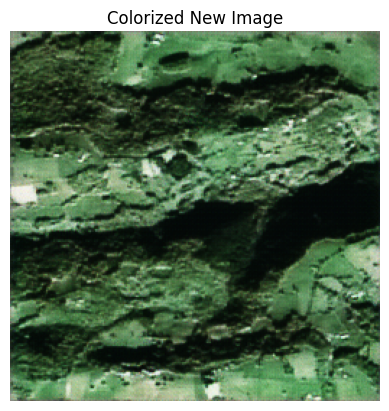

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# Upload an image manually
uploaded = files.upload()
file_path = list(uploaded.keys())[0]  # Get uploaded file name

# Define the U-Net generator
class UNetGenerator(torch.nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, normalize=True):
            layers = [torch.nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
            if normalize:
                layers.append(torch.nn.BatchNorm2d(out_channels))
            layers.append(torch.nn.LeakyReLU(0.2))
            return torch.nn.Sequential(*layers)

        def up_block(in_channels, out_channels, dropout=0.0):
            layers = [torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                      torch.nn.BatchNorm2d(out_channels),
                      torch.nn.ReLU(inplace=True)]
            if dropout:
                layers.append(torch.nn.Dropout(dropout))
            return torch.nn.Sequential(*layers)

        self.down1 = down_block(in_channels, 64, normalize=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)
        self.down7 = down_block(512, 512)
        self.down8 = down_block(512, 512, normalize=False)

        self.up1 = up_block(512, 512, dropout=0.5)
        self.up2 = up_block(1024, 512, dropout=0.5)
        self.up3 = up_block(1024, 512, dropout=0.5)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.up8 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))

        return u8

# Load the trained generator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = UNetGenerator(in_channels=1, out_channels=3).to(device)

#Fix: Load model with weights_only=False
model_filename = "generator_epoch.pth"  # Ensure this file exists in your Colab environment
try:
    generator.load_state_dict(torch.load(model_filename, map_location=device, weights_only=False))
    print(" Model loaded successfully!")
except RuntimeError:
    print(" Failed to load state_dict. Trying full model loading...")
    generator = torch.load(model_filename, map_location=device)
    generator.to(device)
    print(" Full model loaded successfully!")

generator.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # If this gives bad results, remove it
])

# Function to transform a single image
def transform_image(input_img_path):
    input_img = Image.open(input_img_path).convert('L')  # Convert to grayscale
    input_img = transform(input_img)
    input_img = input_img.unsqueeze(0).to(device)  # Add batch dimension

    # Generate the colorized image
    with torch.no_grad():
        fake_img = generator(input_img)
        fake_img = (fake_img * 0.5) + 0.5  # Rescale to [0, 1]
        fake_img = fake_img.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Convert to PIL Image
    fake_img = (fake_img * 255).astype("uint8")
    return Image.fromarray(fake_img)

# Transform and display the uploaded image
colorized_img = transform_image(file_path)

# Display the image
plt.imshow(colorized_img)
plt.axis('off')
plt.title('Colorized New Image')
plt.show()


In [ ]:
import os
print(os.listdir())

['.config', 'ROIs1868_summer_s2_59_p431.png', 'ROIs1868_summer_s2_59_p15 (3).png', 'ROIs1868_summer_s2_59_p15 (2).png', 'ROIs1868_summer_s2_59_p15 (1).png', 'ROIs1868_summer_s2_59_p30.png', 'ROIs1868_summer_s2_59_p15.png', 'ROIs1868_summer_s2_59_p78.png', 'drive', 'sample_data']


# New Section